In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
import h5py
import pandas

from scipy.stats import zscore

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import vm_tools as vmt
from matplotlib.colors import Normalize

def overlay_brain(data, brain, threshold=None, 
                  cmap='RdBu_r', vmin=None, vmax=None):
    alpha = (np.abs(data) > threshold).astype(np.float)
    alpha_brain = alpha.reshape(brain.shape)
    nrm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    nrm2 = Normalize()
    br = nrm2(brain)
    cmap = getattr(plt.cm, cmap)
    data_color = cmap(nrm(data))
    data_brain = data_color.reshape(brain.shape + (4,))
    nr, nc = vmt.plot_utils.find_squarish_dimensions(brain.shape[0])
    fig, axs = plt.subplots(int(nr), int(nc), figsize=(10,10))
    for i, (ax, dsl, bsl, asl) in enumerate(zip(axs.flatten(), data_brain, brain, alpha_brain)):
        gray_im = plt.cm.gray(nrm2(bsl))
        #print(asl.max())
        im = dsl[...,:3] * asl[:,:,np.newaxis] + gray_im[...,:3] * (1-asl[:,:,np.newaxis])
        ax.imshow(im)
        ax.axis('off')
    for j in range(i+1, len(axs.flatten())):
        axs.flatten()[j].axis('off')

Failed to import:
No module named 'hyperopt'
No generalized Tikhonov fit available for regression


/home/mark/Code/vm_tools/vm_tools/__init__.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", li

In [3]:
fdir = '/unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/'
glob.glob(fdir + '*xls*')

['/unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/Sub03_Run_Breakdown.xls',
 '/unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/Subject 3 Runs with specific object info.xlsx']

In [4]:
# Load two excel files as data frames in pandas
df1 = pandas.read_excel(os.path.join(fdir, 'Sub03_Run_Breakdown.xls'))
df2 = pandas.read_excel(os.path.join(fdir, 'Subject 3 Runs with specific object info.xlsx'))

In [5]:
# Extract useful variables
# For the first xls file
run = df1['Run'].values
onset = df1['BV Start'].values
offset = df1['BV Stop'].values
cat = df1['Run6'].values
# Separate indices for the second xls file
objects = df2['object'].values
# A little cleanup to get rid of extra quotes
print(objects[:3]) # before
objects = np.array([o.strip("'''") for o in objects])
print(objects[:3]) # after (no extra quotes)
conditions = df2['condition'].values
# Similar cleanup
conditions = np.array([c.strip("'") for c in conditions])
object_run = df2['run'].values

["'''Head phones'''" "'''Ice cream scoop'''" "'''Bandages'''"]
['Head phones' 'Ice cream scoop' 'Bandages']


In [6]:
cond2number = {'real':0, 'photo':1, 'foil':2}

In [9]:
# Start with a list
X_list = []
n_runs = 7
n_TRs_per_run = 127
n_conditions = 3 # could be: n_features. If so don't forget to change it below.
for this_run in range(1, n_runs+1):
    Xtmp = np.zeros((n_TRs_per_run, n_conditions))
    ri_xls1 = run==this_run
    ri_xls2 = object_run==this_run
    # -1 because python wants zero-based indices
    # xls1 is too long - not just trials, but 3 values per trial. thus, fancier selection
    # Word onsets were when it was NOT fixation and NOT response
    word_on = ~((cat[ri_xls1]=='Fixation') | (cat[ri_xls1]=='Response'))
    all_onsets_thisrun = onset[ri_xls1]
    word_onsets_thisrun = all_onsets_thisrun[word_on]
    
    conds_thisrun = conditions[ri_xls2]
    objects_thisrun = conditions[ri_xls2]
    # All of these variables should always be 24 long for this experiment
    #print(len(objects_thisrun))
    #print(len(conds_thisrun))
    #print(len(word_onsets_thisrun))
    for itrial in range(0,24):
        on = word_onsets_thisrun[itrial]
        o = objects_thisrun[itrial]
        cond = conds_thisrun[itrial]
        cond_idx = cond2number[cond]
        # OR: define object2feature (see below), and call this:
        #feature_idx = object2feature[o]
        # ... and then use feature_idx as the index for Xtmp in the next line 
        # instead of cond_idx
        Xtmp[on, cond_idx] = 1
    # For each run, add the X variable we have created to a list:
    X_list.append(Xtmp)
# ... and concatenate everything here:
X = np.vstack(X_list)

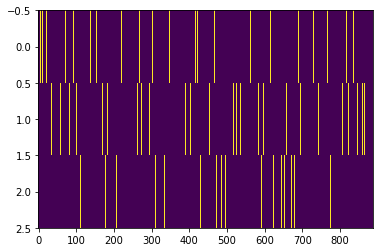

In [10]:
plt.imshow(X.T, aspect='auto')

# fMRI data

In [11]:
fdir = '/unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/'
all_files = sorted(glob.glob(fdir + '*mat'))
unsmoothed_files = all_files[::2]
smoothed_files = all_files[1::2]

In [12]:
# Create a list for data
data = []
# Load each file into list
for file in smoothed_files:
    print("Loading %s"%file)
    with h5py.File(file) as hf:
        d = hf['data'].value
    #print('Original size: ', d.shape)
    # Transpose data so time is first axis
    d = d.T
    # Map the 4 values returned by d.shape to separate variables
    t, z, y, x = d.shape
    #print('Transposed size: ', d.shape)
    # Reshape data to be time x (all voxels)
    d = np.reshape(d, (127, -1)) # the -1 here means string everything all out into one vector
    #print('Reshaped size: ', d.shape)
    # standardize by run, because that makes many things easier
    data.append(zscore(d, axis=0))

Loading /unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/SUB03_RUN01_SCSAI_3DMCS_THPGLMF2c_TAL_SD3DVSS6.00mm.mat
Loading /unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/SUB03_RUN02_SCSAI_3DMCS_THPGLMF2c_TAL_SD3DVSS6.00mm.mat


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:2248: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


Loading /unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/SUB03_RUN03_SCSAI_3DMCS_THPGLMF2c_TAL_SD3DVSS6.00mm.mat
Loading /unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/SUB03_RUN04_SCSAI_3DMCS_THPGLMF2c_TAL_SD3DVSS6.00mm.mat
Loading /unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/SUB03_RUN05_SCSAI_3DMCS_THPGLMF2c_TAL_SD3DVSS6.00mm.mat
Loading /unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/SUB03_RUN06_SCSAI_3DMCS_THPGLMF2c_TAL_SD3DVSS6.00mm.mat
Loading /unrshare/LESCROARTSHARE/data_PSY763/SnowLabData/SUB03_RUN07_SCSAI_3DMCS_THPGLMF2c_TAL_SD3DVSS6.00mm.mat


In [13]:
Y = np.nan_to_num(np.vstack(data))
print(Y.shape)

(889, 106720)


In [35]:
import fmri

In [38]:
from __init__ import *

In [40]:
Bb = ols(Xh[:n_est], Y[:n_est])

In [41]:
Bb.shape

(9, 106720)

In [42]:
np.allclose(Bh.T, Bb)

True

In [14]:
# Get a brain while we're at it
with h5py.File(unsmoothed_files[0]) as hf:
    dd = hf['data'].value
    print(dd.shape)
    brain = dd.T.mean(0)

(46, 40, 58, 127)


In [15]:
from sklearn import linear_model as lm

In [16]:
Xh = vmt.utils.add_lags(X, lags=[1,2,3])

In [17]:
ols = lm.LinearRegression(fit_intercept=False)

In [18]:
n_est = -200
ols = ols.fit(Xh[:n_est], Y[:n_est])

In [19]:
y_hat = ols.predict(Xh[n_est:])
r = vmt.Stats.utils.column_corr(y_hat, Y[n_est:])

/home/mark/Code/vm_tools/vm_tools/Stats/utils.py:48: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda x: (x-np.nanmean(x, axis=0))/np.nanstd(x, axis=0, ddof=dof)
/home/mark/Code/vm_tools/vm_tools/Stats/utils.py:54: RuntimeWarning: invalid value encountered in true_divide
  r = rTmp/n


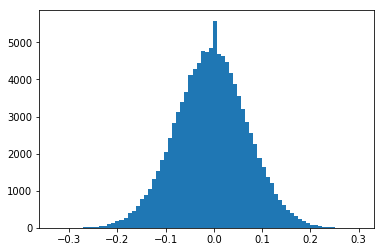

In [20]:
plt.hist(np.nan_to_num(r), bins=75);

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


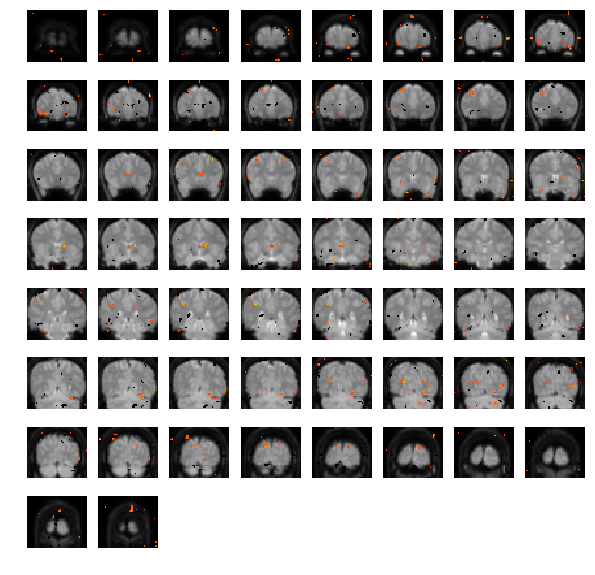

In [21]:
overlay_brain(r, brain, threshold=0.18, cmap='hot', vmin=0, vmax=0.4)

In [24]:
Bh = ols.coef_
Bh.shape

(106720, 9)

In [25]:
B = np.vstack([Bh[:,st::3].mean(1) for st in [0, 1, 2]]).T

In [28]:
Bdif = B[:, 0] - B[:, 1]
Bdif.max(), Bdif.min()

(0.5958710304781604, -0.5560365262951011)

(array([   59.,   950.,  5993., 18782., 32247., 29369., 14369.,  4162.,
          710.,    79.]),
 array([-0.55603653, -0.44084577, -0.32565501, -0.21046426, -0.0952735 ,
         0.01991725,  0.13510801,  0.25029876,  0.36548952,  0.48068027,
         0.59587103]),
 <a list of 10 Patch objects>)

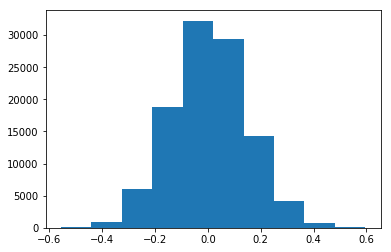

In [30]:
plt.hist(Bdif)

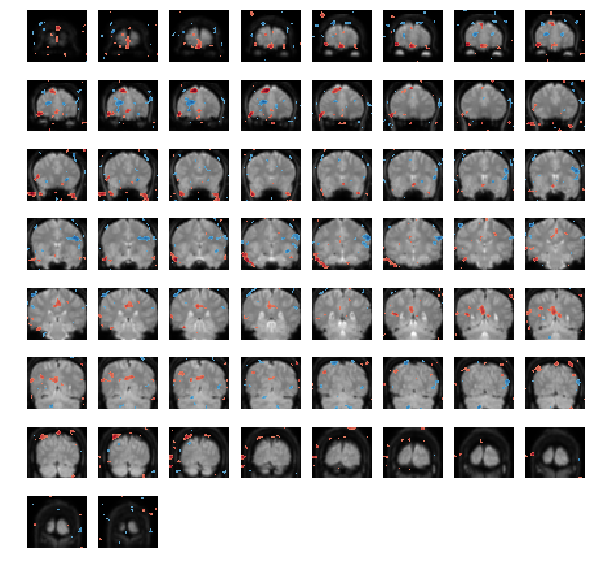

In [29]:
overlay_brain(Bdif, brain, threshold=0.3, vmin=-0.6, vmax=0.6)

In [31]:
Bdif2 = Bh[:,1] - Bh[:,4]

In [43]:
brain.shape

(58, 40, 46)

In [47]:
aa = np.linspace(1, 2, 40)
bb = np.linspace(1, 2, 58)
cc = np.linspace(1, 2, 46)
a, b, c = np.meshgrid(aa, bb, cc)
b.shape

(58, 40, 46)

In [55]:
br_mask = brain < 200

In [56]:
a[br_mask] = 0
b[br_mask] = 0
c[br_mask] = 0

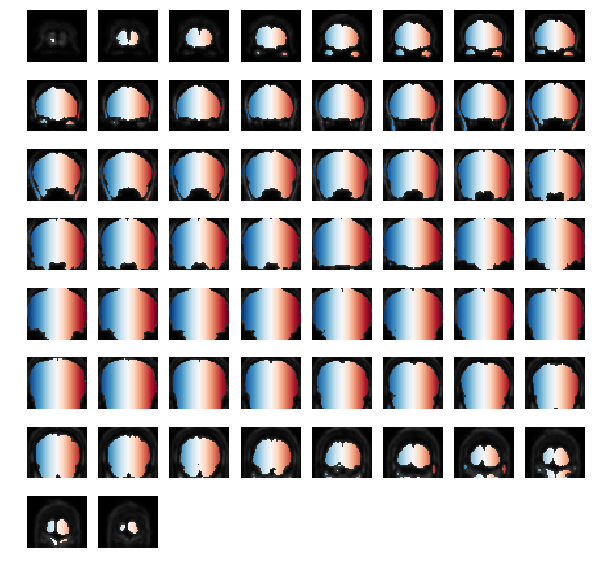

In [59]:
overlay_brain(c.flatten(), brain, threshold=1, vmin=1, vmax=2, cmap='RdBu_r')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


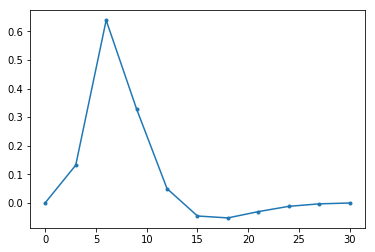

In [31]:
plt.plot(tt, hh, '.-')

In [32]:
Xhh = np.zeros_like(X)
for i, x in enumerate(X.T):
    Xhh[:,i] = np.convolve(x, hh)[:len(x)]

In [33]:
Xhh.shape

(889, 3)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


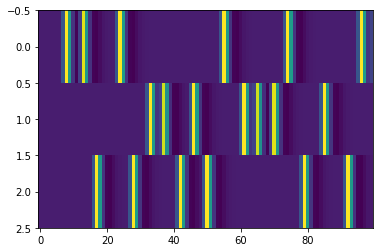

In [34]:
plt.imshow(Xhh[:100].T, aspect='auto')

In [35]:
from __init__ import *

In [63]:
B = ols(Xhh[:-127], Y[:-127])

In [64]:
B.shape

(3, 106720)

In [39]:
brain = get_brain(file)

(46, 40, 58, 127)


In [ ]:
Bdif = np.nan_to_num((B[0] + B[1])/2. - B[2])
fmri.overlay_brain(Bdif, brain, threshold=0.7, vmin=-1.5, vmax=1.5)

In [ ]:
y_hat = Xhh[-127:].dot(B)

r = column_corr(y_hat, Y[-127:])

In [ ]:
plt.hist(np.nan_to_num(r), bins=75);

In [ ]:
fmri.overlay_brain(r, brain, threshold=0.2, cmap='inferno', vmin=0, vmax=0.4)